# Introduction

<div class="alert alert-warning">
<font color=black>

**What?** Leveraging Quantile Regression For AB Test

</font>
</div>

# Import modules

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# Getting rid of the warning messages
import warnings
warnings.filterwarnings("ignore")

# Leveraging Quantile Regression For A/B Test

When launching new features to our product, we often times leverage experiments, or so called A/B tests in order to understand and quantify their impact. Popular statistical methods such as t-test often focuses on calculating **average treatment effects**. Not that there's anything wrong with the approach is just that because average reduces an entire distribution into one single number, any heterogeneity in our distribution may potentially get unnoticed. Keep in mind that in real world settings, negative experience often times stick inside people's head longer and stronger than positive ones. The goal of this notebook is to show how to leverage quantile regression to calculate **quantile treatment effect**, which offers a more precise alternative to only estimating average treatment effects.

We will use the NYCflights13 data to conduct our experiments, which contains over 300,000 observations of flights departing NYC in 2013. We will focus on a single variable, the delay time of flights arrival in minutes.

In [2]:
# constant column names used across the notebook
arr_delay = 'arr_delay'
airline_name = 'name'


def read_data(path='../DATASETS/flights.csv'):
    """Will try and download the data to local [path] if it doesn't exist."""
    if not os.path.exists(path):
        base_url = 'https://media.githubusercontent.com/media/WillKoehrsen/Data-Analysis/master'
        url = base_url + '/univariate_dist/data/formatted_flights.csv'
        df = pd.read_csv(url, usecols=[arr_delay, airline_name])
        df.to_csv(path, index=False)
    else:
        df = pd.read_csv(path, usecols=[arr_delay, airline_name])

    return df

In [3]:
df = read_data()
print(df.shape)
df.head()

(317113, 2)


,arr_delay,name
0,11.0,United Air Lines Inc.
1,20.0,United Air Lines Inc.
2,33.0,American Airlines Inc.
3,-18.0,JetBlue Airways
4,-25.0,Delta Air Lines Inc.


To start with, we'll use [density plot](https://serialmentor.com/dataviz/histograms-density-plots.html) to visualize the distribution of the `arr_delay` field. For those that are not familiar, think of it as a continuous version of histogram (The plot below overlays density plot on top of histogram).

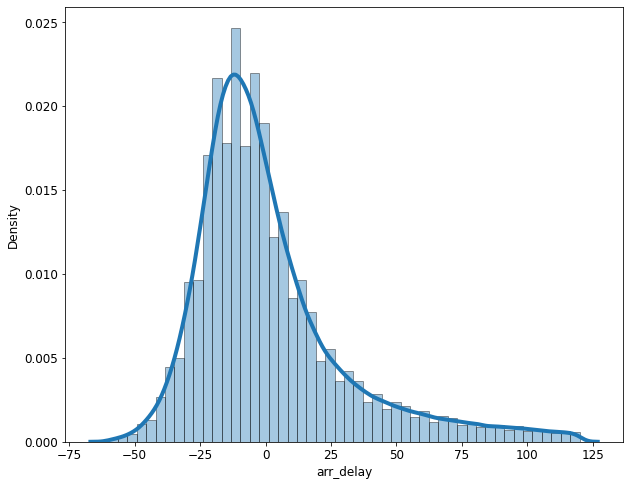

In [4]:
# change default style figure and font size
plt.rcParams['figure.figsize'] = 10, 8
plt.rcParams['font.size'] = 12


sns.distplot(df[arr_delay], hist=True, kde=True,
             hist_kws={'edgecolor': 'black'},
             kde_kws={'linewidth': 4})

plt.show()

Now, let's say we would like to use this data and compare the arrive time delay of two airlines and once again we'll use our good old density plot to visualize and compare the two airline's arrival time distribution.

> Not affiliated with any one of the airline in anyway and neither is this data guaranteed to be up to date with the status quo.

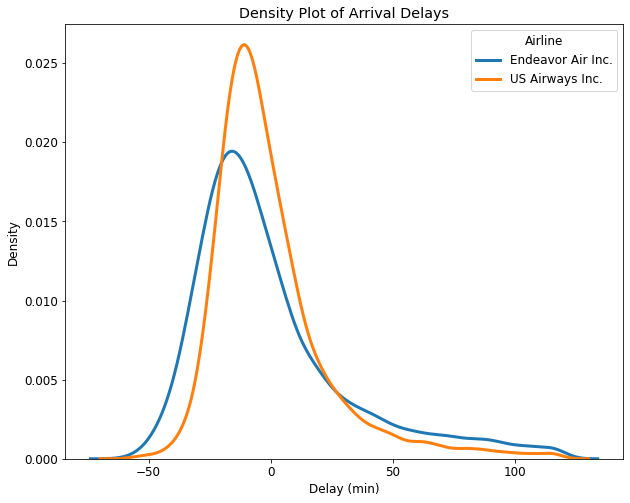

In [5]:
endeavor_airline = 'Endeavor Air Inc.'
us_airway_airline = 'US Airways Inc.'

for airline in [endeavor_airline, us_airway_airline]:
    subset = df[df[airline_name] == airline]

    sns.distplot(subset[arr_delay], hist=False, kde=True,
                 kde_kws={'shade': False, 'linewidth': 3}, label=airline)

plt.legend(prop={'size': 12}, title='Airline')
plt.title('Density Plot of Arrival Delays')
plt.xlabel('Delay (min)')
plt.ylabel('Density')
plt.show()

After visualizing the arrival time on the two airlines, we can see that although both distribution seems to be centered around the same area, the tail-end of both side tells a different story, where one of the airline shows that it has a larger tendency of resulting in a delay.

If we were to leverage the two sample t-test to compare the means of two separate samples. We would see that the statistical test would tell us we can't reject the null hypothesis and there is no statistically significant difference between the arrival delay time of the two airlines.

In [6]:
airline1_delay = df.loc[df[airline_name] == endeavor_airline, arr_delay]
airline2_delay = df.loc[df[airline_name] == us_airway_airline, arr_delay]

result = stats.ttest_ind(airline1_delay, airline2_delay, equal_var=True)
result

Ttest_indResult(statistic=0.7092441508007634, pvalue=0.4781775570341349)

We can also leverage a single binary variable linear regression to arrive at the same conclusion as the two sample t-test above. The step to do this is do convert our airline variable into a dummy variable and fit a linear regression using the dummy variable as the input feature and the arrival delay time as the response variable.

In [7]:
mask = df[airline_name].isin([endeavor_airline, us_airway_airline])
df_airline_delay = df[mask].reset_index(drop=True)

y = df_airline_delay[arr_delay]
X = pd.get_dummies(df_airline_delay[airline_name], drop_first=True)
X.head()

,US Airways Inc.
0,1
1,1
2,1
3,1
4,1


We'll be using `statsmodel` to build the linear regression as it gives R-like statistical output. For people coming from `scikit-learn`, y variable comes first in statsmodel and by default, it doesn't automatically fit a constant/intercept, so we'll need to add it ourselves.

In [8]:
# ordinary least square
model = sm.OLS(y, sm.add_constant(X))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              arr_delay   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.5030
Date:                Sat, 23 Oct 2021   Prob (F-statistic):              0.478
Time:                        20:09:11   Log-Likelihood:            -1.7154e+05
No. Observations:               36125   AIC:                         3.431e+05
Df Residuals:                   36123   BIC:                         3.431e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.2619      0.217     -1.207      0.227      -0.687       0.163
US Airways Inc.    -0.2092      0.295     -0.709      0.478      -0.787       0.369
==============================================================================
Omnibus:                    10940.592   Durbin-Watson:                   1.381
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            31155.807
Skew:                           1.609   Prob(JB):                         0.00
Kurtosis:                       6.215   Cond. No.                         2.73
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Notice that the numbers for the t-statistic and p-value matches the two-sample t-test result above. The benefit of using a linear regression is that, we can include many other features to see if they are the reasons behind the arrival delay.

By looking at average treatment effect, we can see that we would be drawing the conclusion that there is no statistical difference in the two airlines' arrival time, however, based on looking that the distribution of two airline's arrival delay, our hunch tells us that we're probably missing something. This is where estimating quantile treatment effect really provide additional insights not found by simply looking at the average treatment effects. To do so, we change our model to a quantile regression and specify the quantile we are interested in.

In [9]:
model = sm.QuantReg(y, sm.add_constant(X))
result = model.fit(q=0.9, kernel='gau')
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:              arr_delay   Pseudo R-squared:              0.01632
Model:                       QuantReg   Bandwidth:                       2.677
Method:                 Least Squares   Sparsity:                        297.1
Date:                Sat, 23 Oct 2021   No. Observations:                36125
Time:                        20:09:11   Df Residuals:                    36123
                                        Df Model:                            1
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              44.0000      0.692     63.603      0.000      42.644      45.356
US Airways Inc.   -16.0000      0.944    -16.954      0.000     -17.850     -14.150
===================================================================================
"""

At 0.9 quantile, we were able to detect a statistically significant effect!

We can of course, also compute this across multiples quantiles and plot the quantile treatment effect in a single figure to get a much more nuanced insights into the treatment effect of our experiment that different quantiles. This allows us the detect for extreme scenarios where a single two-sample t-tests would fail raise any concerns towards the experiment.

In [10]:
def compute_quantile_treatment_effect(X, y, quantiles):
    coefs = []
    pvalues = []
    for q in quantiles:
        model = sm.QuantReg(y, sm.add_constant(X))
        result = model.fit(q=q, kernel='gau')

        coef = result.params[1]
        coefs.append(coef)

        pvalue = result.pvalues[1]
        pvalues.append(pvalue)

    coef_name = result.params.index[1]

    df_quantile_effect = pd.DataFrame({
        'quantile': quantiles,
        coef_name: coefs,
        'pvalue': pvalues
    })
    return df_quantile_effect


quantiles = np.arange(0.1, 1.0, 0.1)
df_quantile_effect = compute_quantile_treatment_effect(X, y, quantiles)
df_quantile_effect

,quantile,US Airways Inc.,pvalue
0,0.1,8.000005,1.040500e-226
1,0.2,6.999999,1.185948e-246
2,0.3,5.999997,5.233626e-179
3,0.4,4.000000,4.048937e-72
4,0.5,2.999995,1.846561e-34
5,0.6,1.999995,6.457823e-12
6,0.7,-1.000001,4.946187e-03
7,0.8,-6.000002,2.991759e-30
8,0.9,-16.000001,3.194679e-64


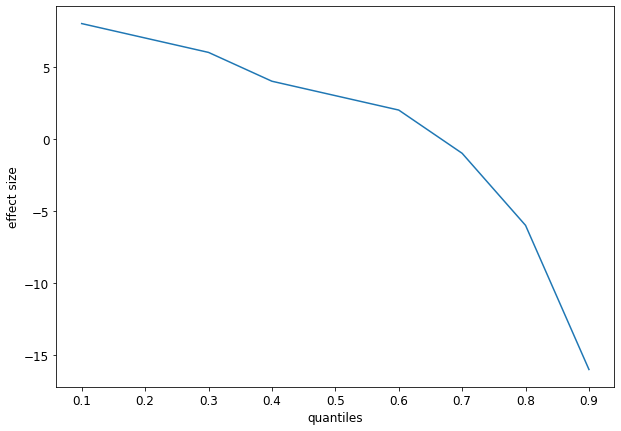

In [11]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)

ax.plot(df_quantile_effect['quantile'], df_quantile_effect['US Airways Inc.'])
ax.set_xlabel('quantiles')
ax.set_ylabel('effect size')
plt.show()

# Reference

- [Blog: Histograms and Density Plots in Python](https://towardsdatascience.com/histograms-and-density-plots-in-python-f6bda88f5ac0)
- [Blog: Comparative Statistics in Python using SciPy](http://benalexkeen.com/comparative-statistics-in-python-using-scipy/)
- [Blog: Analyzing Experiment Outcomes: Beyond Average Treatment Effects](https://eng.uber.com/analyzing-experiment-outcomes/)
- [Online Book: Visualizing distributions: Histograms and density plots](https://serialmentor.com/dataviz/histograms-density-plots.html)
- [Code taken from here](https://github.com/ethen8181/machine-learning/blob/master/ab_tests/quantile_regression/ab_test_regression.ipynb)